In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [1]:
# ACTIONS
MOVE_RIGHT         = 0
MOVE_DOWN          = 1
SCALE_UP           = 2
ASPECT_RATIO_UP    = 3
MOVE_LEFT          = 4
MOVE_UP            = 5
SCALE_DOWN         = 6
ASPECT_RATIO_DOWN  = 7
SPLIT_HORIZONTAL   = 8
SPLIT_VERTICAL     = 9
SKIP_REGION        = 10
PLACE_LANDMARK     = 11


DIMENSION = 224
STEP_FACTOR = 0.2
MAX_ASPECT_RATIO = 6.00
MIN_ASPECT_RATIO = 0.15
MIN_BOX_SIDE     = 10

class ObjLocaliser(object):
        
    def __init__(self, image, boundingBoxes):
        
        #Loading image using PIL librarry to resize it to standard dimention which is acceptable by the network
        #PILimg = Image.fromarray(image)
        PILimg = image
        #Resizing the image to be compatible to the network
        resized_img = PILimg.resize((DIMENSION,DIMENSION))
        #Image is stored as np array
        self.image_playground = np.array(resized_img)
        
        #Computing the scale of resize to recompute the position of bounding boxes
        #self.x_scale = 224./im2.size[0]
        #self.y_scale = 224./im2.size[1]
        
        #Multiplying xmin and xmax of boxes by x_scale and ymax and ymin by y_scale
        #self.xmin =
        #self.xmax =
        #self.ymin =
        #self.ymax =
        self.targets = self.gettingTargerReady(boundingBoxes)
        #Initializing sliding window from top left corner of the image
        #[x_top_left_corner, y_top_left_corner, x_down_right_corner, y_down_right_corner]
        #self.agent_window = np.array([0,0,DIMENSION,DIMENSION])
        self.agent_window = np.array([0,0,100,50])
        self.iou = 0

        
        self.actoins = {
            0: 'MOVE_RIGHT',
            1: 'MOVE_DOWN',
            2: 'SCALE_UP',
            3: 'ASPECT_RATIO_UP',
            4: 'MOVE_LEFT',
            5: 'MOVE_UP',
            6: 'SCALE_DOWN',
            7: 'ASPECT_RATIO_DOWN',
            8: 'SPLIT_HORIZONTAL',
            9: 'SPLIT_VERTICAL',
            10: 'SKIP_REGION',
            11: 'PLACE_LANDMARK'
        }
        
        
        
    def gettingTargerReady(self, boundingBoxes):
        numOfObj = len(boundingBoxes['xmax'])
        objs = []
        for i in range(numOfObj):
            temp = [boundingBoxes['xmin'][i], boundingBoxes['xmax'][i], boundingBoxes['ymin'][i], boundingBoxes['ymax'][i]]
            objs.append(temp)
        return objs
        
    def wrapping(self):
        
        #Pick selected window from image
        im2 = self.image_playground[self.agent_window[1]:self.agent_window[3],self.agent_window[0]:self.agent_window[2]]
        #Resizing the agent window to be compatible for network input
        resized = Image.fromarray(im2).resize((DIMENSION,DIMENSION))
        return resized
    
    
    def takingActions(self,action):

        newbox = np.array([0,0,0,0])
        
        if action == MOVE_RIGHT:           
            newbox = self.MoveRight()
        elif action == MOVE_DOWN:         
            newbox = self.MoveDown()
        elif action == SCALE_UP:           
            newbox = self.scaleUp()
        elif action == ASPECT_RATIO_UP:    
            newbox = self.aspectRatioUp()
        elif action == MOVE_LEFT:       
            newbox = self.MoveLeft()
        elif action == MOVE_UP:       
            newbox = self.MoveUp()
        elif action == SCALE_DOWN:         
            newbox = self.scaleDown()
        elif action == ASPECT_RATIO_DOWN:  
            newbox = self.aspectRatioDown()
        elif action == SPLIT_HORIZONTAL:   
            newbox = self.splitHorizontal()
        elif action == SPLIT_VERTICAL:     
            newbox = self.splitVertical()
        #elif action == SKIP_REGION:        
            #self.skipRegion()
        #elif action == PLACE_LANDMARK:     
            #self.placeLandmark()
            
        self.agent_window = newbox
        self.adjustAndClip()
        r = self.ComputingReward()
            
        return r
        
     


    def MoveRight(self):
        
        newbox = self.agent_window 
        boxW = self.agent_window[2] - self.agent_window[0]
        step = STEP_FACTOR * boxW
        # This action preserves box width and height
        if self.agent_window[2] + step < self.image_playground.shape[0]:
            newbox[0] += step
            newbox[2] += step
        else:
            newbox[0] = self.image_playground.shape[0] - boxW - 1
            newbox[2] = self.image_playground.shape[0] - 1 
            
        return newbox
            
            

    def MoveDown(self):
        
        newbox = self.agent_window 
        boxH = self.agent_window[3] - self.agent_window[1]
        step = STEP_FACTOR * boxH
        # This action preserves box width and height
        if self.agent_window[3] + step < self.image_playground.shape[1]:
            newbox[1] += step
            newbox[3] += step
        else:
            newbox[1] = self.image_playground.shape[1] - boxH - 1
            newbox[3] = self.image_playground.shape[1] - 1
            
        return newbox
        
        
        
        
        
    def scaleUp(self):
        
        newbox = self.agent_window 
        boxW = self.agent_window[2] - self.agent_window[0]
        boxH = self.agent_window[3] - self.agent_window[1]
        
        # This action preserves aspect ratio
        widthChange = STEP_FACTOR * boxW
        heightChange = STEP_FACTOR * boxH
        
        if boxW + widthChange < self.image_playground.shape[0]:
            if boxH + heightChange < self.image_playground.shape[1]:
                newDelta = STEP_FACTOR
            else:
                newDelta = self.image_playground.shape[1] / boxH - 1
        else:
            newDelta = self.image_playground.shape[0] / boxW - 1
            if boxH + (newDelta * boxH) >= self.image_playground.shape[1]:
                newDelta = self.image_playground.shape[1] / boxH - 1
        
        widthChange = newDelta * boxW / 2.0
        heightChange = newDelta * boxH / 2.0
        newbox[0] -= widthChange
        newbox[1] -= heightChange
        newbox[2] += widthChange
        newbox[3] += heightChange
        
        return newbox

        
        

    def aspectRatioUp(self):

        newbox = self.agent_window
        boxH = self.agent_window[3] - self.agent_window[1]
        boxW = self.agent_window[2] - self.agent_window[0]
        
        # This action preserves width
        heightChange = STEP_FACTOR * boxH
        
        if boxH + heightChange < self.image_playground.shape[1]:
            ar = (boxH + heightChange) / boxW
            if ar < MAX_ASPECT_RATIO:
                newDelta = STEP_FACTOR
            else:
                newDelta = 0.0
        else:
            newDelta = self.agent_window[1] / boxH - 1
            ar = (boxH + newDelta * boxH) / boxW
            if ar > MAX_ASPECT_RATIO:
                newDelta =  0.0
                
        heightChange = newDelta * boxH / 2.0
        newbox[1] -= heightChange
        newbox[3] += heightChange
        
        return newbox

        
        
    def MoveLeft(self):
        
        newbox = self.agent_window
        boxW = self.agent_window[2] - self.agent_window[0]
        step = STEP_FACTOR * boxW
        
        # This action preserves box width and height
        if self.agent_window[0] - step >= 0:
            newbox[0] -= step
            newbox[2] -= step
        else:
            newbox[0] = 0
            newbox[2] = boxW
        
        return newbox


    def MoveUp(self):

        newbox = self.agent_window
        
        boxH = self.agent_window[3] - self.agent_window[1]
        
        step = STEP_FACTOR * boxH
        # This action preserves box width and height
        if self.agent_window[1] - step >= 0:
            newbox[1] -= step
            newbox[3] -= step
        else:
            newbox[1] = 0
            newbox[3] = boxH

        return newbox
            

    def scaleDown(self):
        
        newbox = self.agent_window
        
        boxH = self.agent_window[3] - self.agent_window[1]
        boxW = self.agent_window[2] - self.agent_window[0]
        
        # This action preserves aspect ratio
        widthChange = STEP_FACTOR * boxW
        heightChange = STEP_FACTOR * boxH
        
        if boxW - widthChange >= MIN_BOX_SIDE:
            if boxH - heightChange >= MIN_BOX_SIDE:
                newDelta = STEP_FACTOR
            else:
                newDelta = MIN_BOX_SIDE / boxH - 1
        else:
            newDelta = MIN_BOX_SIDE / boxW - 1
            if  boxH - newDelta *  boxH < MIN_BOX_SIDE:
                newDelta = MIN_BOX_SIDE /  boxH - 1
        widthChange = newDelta * boxW / 2.0
        heightChange = newDelta * boxH / 2.0
        newbox[0] += widthChange
        newbox[1] += heightChange
        newbox[2] -= widthChange
        newbox[3] -= heightChange
        
        return newbox

        
        
    def splitHorizontal(self):
        
        newbox = self.agent_window
        boxW = self.agent_window[2] - self.agent_window[0]
        if boxW >  MIN_BOX_SIDE:
            half = boxW / 2.0
            newbox[2] -= half
        return newbox

    def splitVertical(self): 
        
        newbox = self.agent_window
        boxH = self.agent_window[3] - self.agent_window[1]
        if boxH > MIN_BOX_SIDE:
            half = boxH/2.0
            newbox[3] -= half
        return newbox
        
        
    def aspectRatioDown(self):

        newbox = self.agent_window
        
        boxW = self.agent_window[2] - self.agent_window[0]
        boxH = self.agent_window[3] - self.agent_window[1]

        # This action preserves height
        widthChange = STEP_FACTOR * boxW
        if boxW + widthChange < self.image_playground.shape[0]:
            ar = boxH / (boxW + widthChange)
            if ar >= MIN_ASPECT_RATIO:
                newDelta = STEP_FACTOR
            else:
                newDelta = 0.0
        else:
            newDelta = self.image_playground.shape[0] / boxW - 1
            ar = boxH / (boxW + newDelta * boxW)
            if ar < MIN_ASPECT_RATIO:
                newDelta =  0.0
        widthChange = newDelta * boxW / 2.0
        newbox[0] -= widthChange
        newbox[2] += widthChange
        return newbox
         
    def placeLandmark(self):
        self.landmarkIndex[ fingerprint(self.box) ] = self.box[:]
        self.stepsWithoutLandmark = 0
        return self.box

        
        
        
        
    def adjustAndClip(self):
        
        #Cheching if x coordinate of the top left corner is out of bound    
        if self.agent_window[0] < 0:
            step = -self.agent_window[0]
            if self.agent_window[2] + step < self.image_playground.shape[0]:
                self.agent_window[0] += step
                self.agent_window[2] += step
            else:
                self.agent_window[0] = 0
                self.agent_window[2] = self.image_playground.shape[0] - 1

        #Cheching if y coordinate of the top left corner is out of bound    
        if self.agent_window[1] < 0:
            step = -self.agent_window[1]
            if self.agent_window[3] + step < self.image_playground.shape[1]:
                self.agent_window[1] += step
                self.agent_window[3] += step
            else:
                self.agent_window[1] = 0
                self.agent_window[3] = self.image_playground.shape[1] - 1

        #Cheching if x coordinate of the bottom right corner is out of bound    
        if self.agent_window[2] >= self.image_playground.shape[0]:
            step = self.agent_window[2] - self.image_playground.shape[0]
            if self.agent_window[0] - step >= 0:
                self.agent_window[0] -= step
                self.agent_window[2] -= step
            else:
                self.agent_window[0] = 0
                self.agent_window[2] = self.image_playground.shape[0] - 1

        #Cheching if y coordinate of the bottom right corner is out of bound    
        if self.agent_window[3] >= self.image_playground.shape[1]:
            step = self.agent_window[3] - self.image_playground.shape[1]
            if self.agent_window[1] - step >= 0:
                self.agent_window[1] -= step
                self.agent_window[3] -= step
            else:
                self.agent_window[1] = 0
                self.agent_window[3] = self.image_playground.shape[1] - 1

                
    def intersectionOverUnion(self, boxA, boxB):
        
        # determine the (x, y)-coordinates of the intersection rectangle
        #boxA = self.agent_window
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # return the intersection over union value
        return iou  
    
    def ComputingReward(self):
        
        new_iou = self.intersectionOverUnion(slef.agent_window, self.targets[0])
        if new_iou - self.iou > 0:
            reward = 1
        elif new_iou - self.iou < 0:
            reward = -1
        elif new_iou - self.iou == 0:
            reward = self.terminationAction()
            
        self.iou = new_iou
        return reward
                
        
        
    def drawActions(self):
                
        # Create figure and axes
        fig,ax = plt.subplots(1)

        # Display the image
        ax.imshow(self.image_playground)

        # Create a Rectangle patch
        rect = patches.Rectangle((self.agent_window[0],self.agent_window[1]),self.agent_window[2]-self.agent_window[0],self.agent_window[3]-self.agent_window[1],linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        plt.show()

        

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
%matplotlib inline
import time

actn = {
    0: 'MOVE_RIGHT',
    1: 'MOVE_DOWN',
    2: 'SCALE_UP',
    3: 'ASPECT_RATIO_UP',
    4: 'MOVE_LEFT',
    5: 'MOVE_UP',
    6: 'SCALE_DOWN',
    7: 'ASPECT_RATIO_DOWN',
    8: 'SPLIT_HORIZONTAL',
    9: 'SPLIT_VERTICAL',
    10: 'SKIP_REGION',
    11: 'PLACE_LANDMARK'
}


# ACTIONS
MOVE_RIGHT         = 0
MOVE_DOWN          = 1
SCALE_UP           = 2
ASPECT_RATIO_UP    = 3
MOVE_LEFT          = 4
MOVE_UP            = 5
SCALE_DOWN         = 6
ASPECT_RATIO_DOWN  = 7
SPLIT_HORIZONTAL   = 8
SPLIT_VERTICAL     = 9
SKIP_REGION        = 10
PLACE_LANDMARK     = 11


im2 = (Image.open('../VOC2012/JPEGImages/2010_000959.jpg'))



0.0


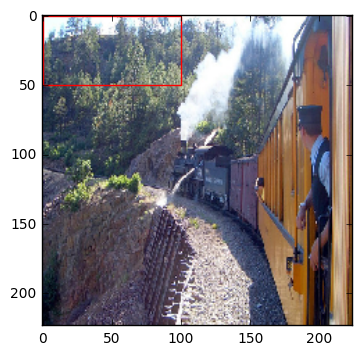

In [15]:
agent = ObjLocaliser(im2,[170,  58, 220, 206])
print agent.intersectionOverUnion(agent.agent_window, [170,  58, 220, 206])
agent.drawActions()


action:MOVE_DOWN
width:100    Height:50
0.0


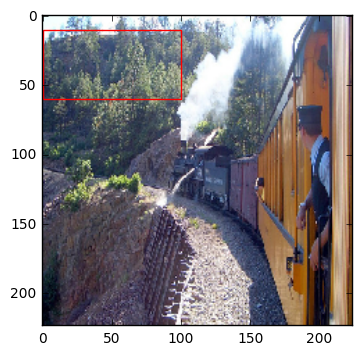

action:MOVE_DOWN
width:100    Height:50
0.0


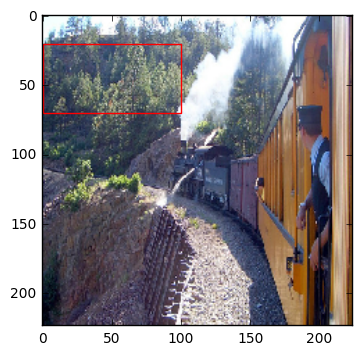

action:MOVE_DOWN
width:100    Height:50
0.0


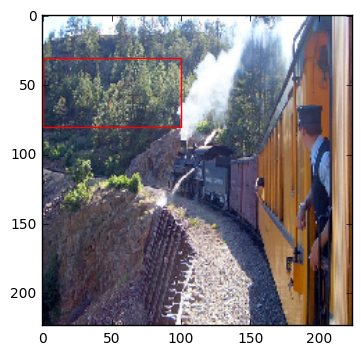

action:MOVE_RIGHT
width:100    Height:50
0.0


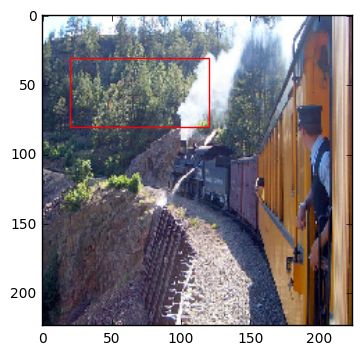

action:MOVE_RIGHT
width:100    Height:50
0.0


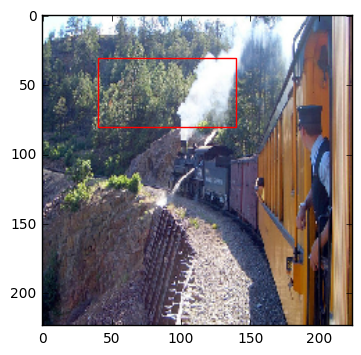

action:MOVE_RIGHT
width:100    Height:50
0.0


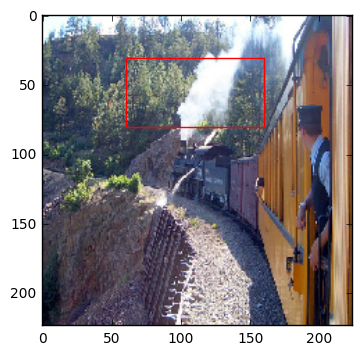

action:MOVE_RIGHT
width:100    Height:50
0.020244858766103865


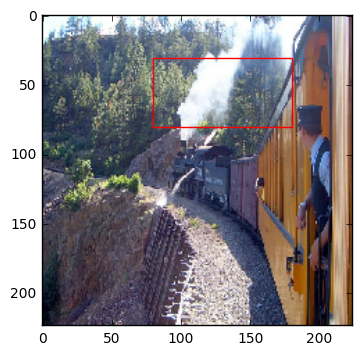

action:MOVE_RIGHT
width:100    Height:50
0.05923402841239511


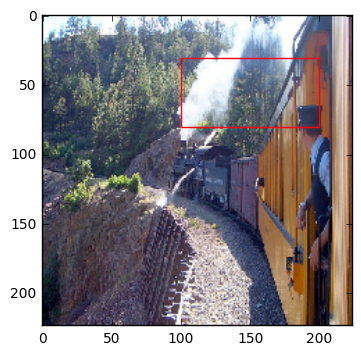

action:MOVE_RIGHT
width:100    Height:50
0.1013215859030837


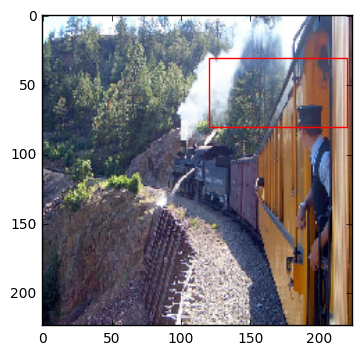

action:ASPECT_RATIO_UP
width:100    Height:60
0.11579630230295167


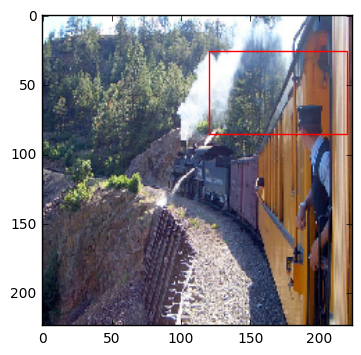

action:ASPECT_RATIO_UP
width:100    Height:72
0.13098655386009972


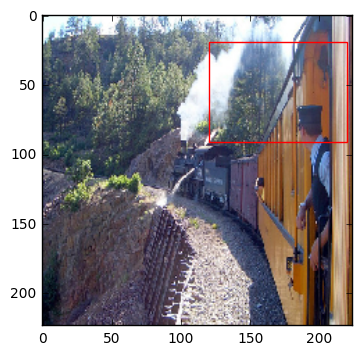

action:ASPECT_RATIO_UP
width:100    Height:87
0.14524868018894138


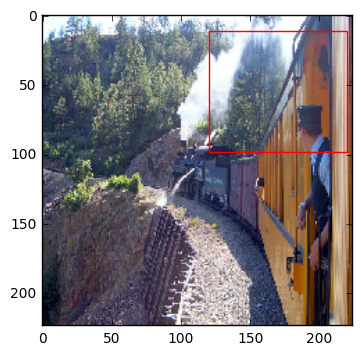

action:ASPECT_RATIO_UP
width:100    Height:104
0.15912129894937918


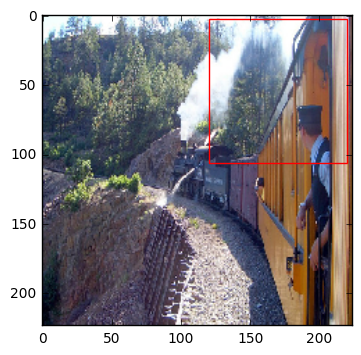

action:ASPECT_RATIO_UP
width:100    Height:124
0.20330814541560063


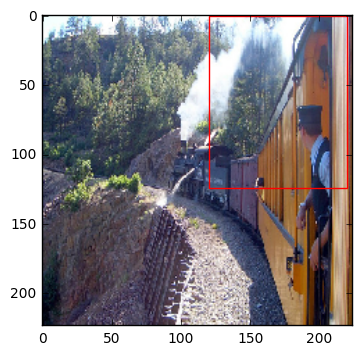

action:ASPECT_RATIO_UP
width:100    Height:148
0.2577331037929694


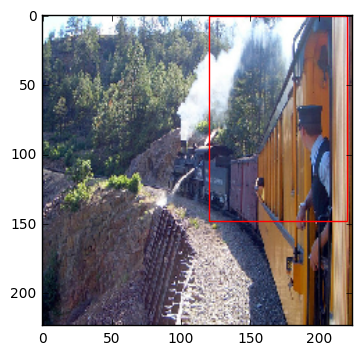

action:MOVE_DOWN
width:100    Height:148
0.3702807357212004


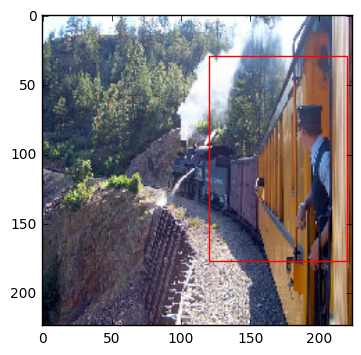

action:MOVE_DOWN
width:100    Height:148
0.504950495049505


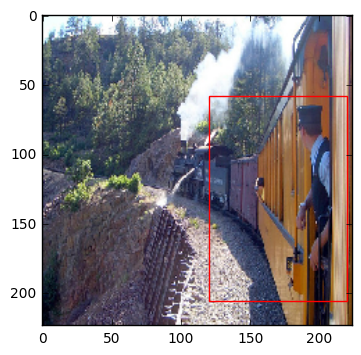

action:SPLIT_HORIZONTAL
width:50    Height:148
0.009900990099009901


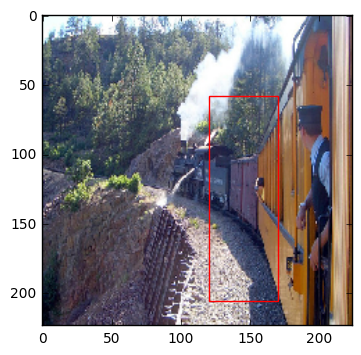

action:MOVE_RIGHT
width:50    Height:148
0.12087912087912088


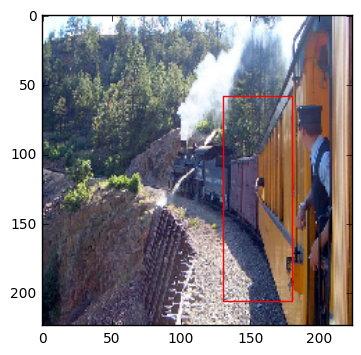

action:MOVE_RIGHT
width:50    Height:148
0.25925925925925924


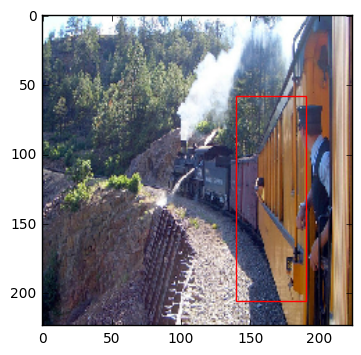

action:MOVE_RIGHT
width:50    Height:148
0.43661971830985913


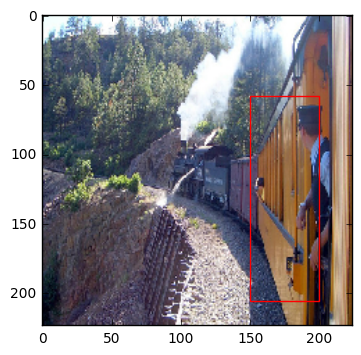

action:MOVE_RIGHT
width:50    Height:148
0.6721311475409836


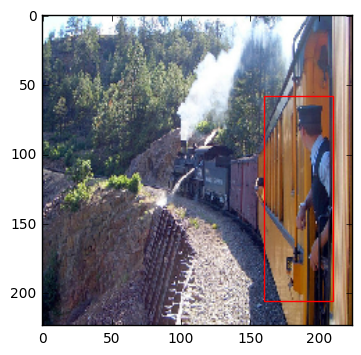

action:MOVE_RIGHT
width:50    Height:148
1.0


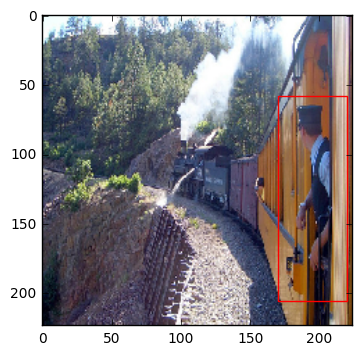

In [16]:
import random
actions = np.array(random.sample(range(0, 10),9))
agent = ObjLocaliser(im2,[])
for act in [1,1,1,0,0,0,0,0,0,3,3,3,3,3,3,1,1,8,0,0,0,0,0]:
    agent.takingActions(act)
    print("action:{0}".format(actn[act]))
    print("width:{0}    Height:{1}".format(agent.agent_window[2] - agent.agent_window[0],agent.agent_window[3] - agent.agent_window[1]))
    print agent.intersectionOverUnion(agent.agent_window, [170,  58, 220, 206])
    agent.drawActions()
    #time.sleep(1)
    

In [135]:
agent.agent_window

array([170,  58, 220, 206])

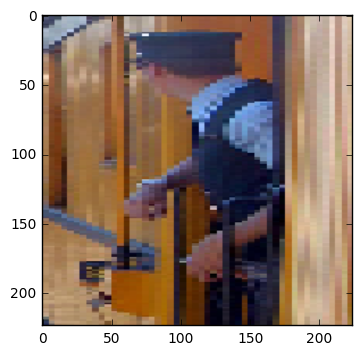

In [136]:
fig,ax = plt.subplots(1)

ax.imshow(agent.wrapping())

In [11]:
import numpy as np
np.random.randint(10, size=1)

array([9, 0, 9, 5, 6, 1, 9, 7, 3, 2, 7, 7, 5, 6, 7])

In [22]:
numOfObj=[]
a=[1,2,3,4]
numOfObj.append(a)
numOfObj.append(a)

In [23]:
numOfObj

[[1, 2, 3, 4], [1, 2, 3, 4]]